In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib


train_df = pd.read_csv('/content/gdrive/MyDrive/Dravidian_sentiment_analysis/Tulu_SA_train.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/Dravidian_sentiment_analysis/Tulu_SA_val.csv')

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text


train_df['Cleaned_Text'] = train_df['Text'].apply(clean_text)
val_df['Cleaned_Text'] = val_df['Text'].apply(clean_text)


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Label'])
y_val = label_encoder.transform(val_df['Label'])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = tfidf_vectorizer.fit_transform(train_df['Cleaned_Text'])
X_val = tfidf_vectorizer.transform(val_df['Cleaned_Text'])


svm_model = SVC(kernel='rbf', probability=True)
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
grid_search = GridSearchCV(svm_model, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)


best_svm_model = grid_search.best_estimator_


print("\nEvaluating on training data:")
train_pred = best_svm_model.predict(X_train)
train_accuracy = (train_pred == y_train).mean()
print(f"Training Accuracy: {train_accuracy:.4f}")

print("\nEvaluating on validation data:")
val_pred = best_svm_model.predict(X_val)
val_accuracy = (val_pred == y_val).mean()
print(f"Validation Accuracy: {val_accuracy:.4f}")


print("\nTraining Classification Report:")
print(classification_report(y_train, train_pred, target_names=[str(label) for label in label_encoder.classes_]))


print("\nValidation Classification Report:")
print(classification_report(y_val, val_pred, target_names=[str(label) for label in label_encoder.classes_]))

joblib.dump(best_svm_model, '/content/gdrive/MyDrive/Dravidian_sentiment_analysis/TL_svm_model.pkl')
joblib.dump(tfidf_vectorizer, '/content/gdrive/MyDrive/Dravidian_sentiment_analysis/TL_svm_tfidf_vectorizer.pkl')
joblib.dump(label_encoder, '/content/gdrive/MyDrive/Dravidian_sentiment_analysis/TL_svm_label_encoder.pkl')


Fitting 3 folds for each of 16 candidates, totalling 48 fits

Evaluating on training data:
Training Accuracy: 0.8734

Evaluating on validation data:
Validation Accuracy: 0.6719

Training Classification Report:
              precision    recall  f1-score   support

       Mixed       0.90      0.50      0.64      1114
    Negative       0.95      0.66      0.78       843
     Neutral       0.82      0.91      0.86      3175
    Not Tulu       0.88      0.97      0.92      4400
    Positive       0.90      0.90      0.90      3769
         nan       0.00      0.00      0.00         7

    accuracy                           0.87     13308
   macro avg       0.74      0.65      0.68     13308
weighted avg       0.88      0.87      0.87     13308


Validation Classification Report:
              precision    recall  f1-score   support

       Mixed       0.35      0.08      0.14       143
    Negative       0.64      0.31      0.41       118
     Neutral       0.56      0.68      0.61      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

['/content/gdrive/MyDrive/Dravidian_sentiment_analysis/TL_svm_label_encoder.pkl']

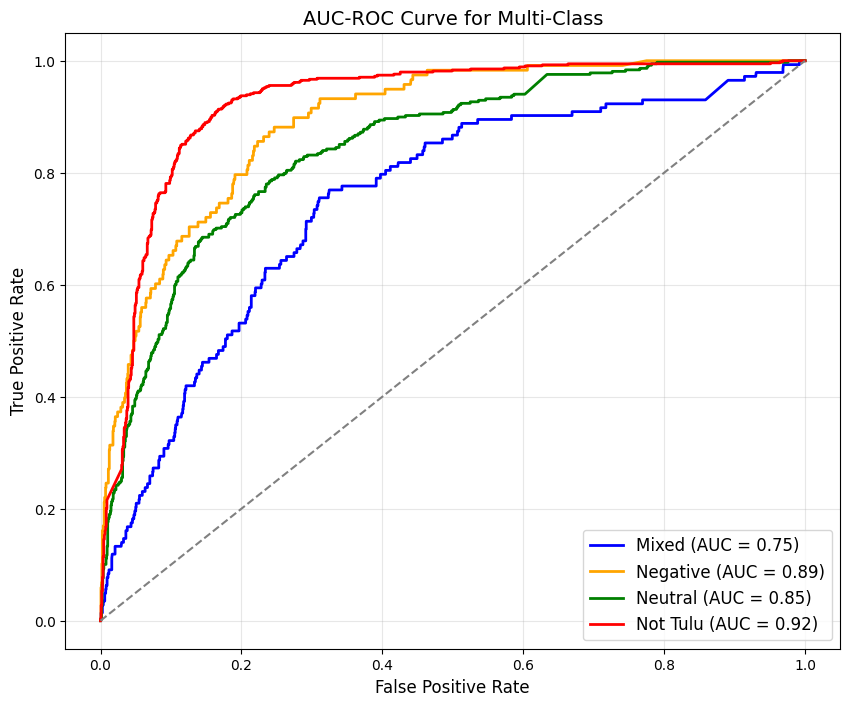

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize


y_train_binarized = label_binarize(y_train, classes=range(len(label_encoder.classes_)))
y_val_binarized = label_binarize(y_val, classes=range(len(label_encoder.classes_)))


val_probs = best_svm_model.predict_proba(X_val)


colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(10, 8))


for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    val_fpr, val_tpr, _ = roc_curve(y_val_binarized[:, i], val_probs[:, i])
    val_auc = roc_auc_score(y_val_binarized[:, i], val_probs[:, i])

    plt.plot(val_fpr, val_tpr, color=color, label=f'{class_name} (AUC = {val_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')


plt.title("AUC-ROC Curve for Multi-Class", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


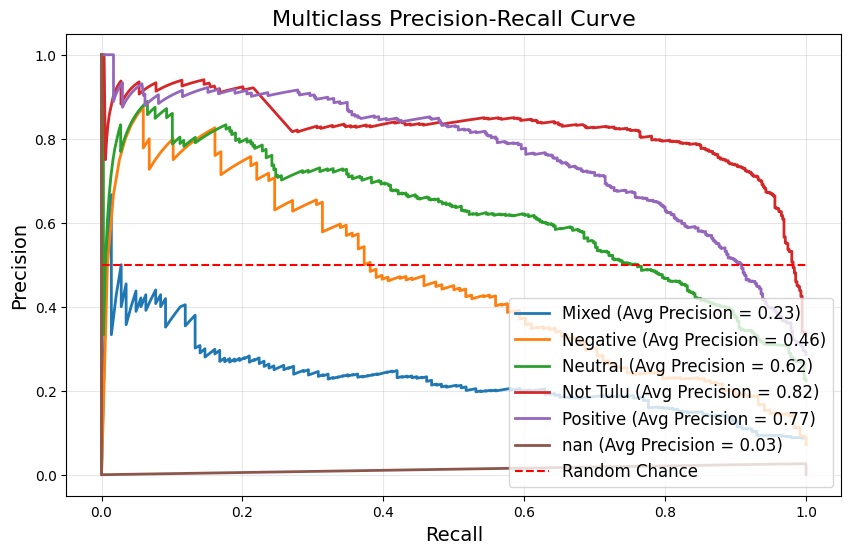

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


n_classes = len(label_encoder.classes_)
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 6))

for i in range(n_classes):
    y_scores = best_svm_model.predict_proba(X_val)[:, i]
    precision, recall, _ = precision_recall_curve(y_val == i, y_scores)
    avg_precision = average_precision_score(y_val == i, y_scores)

    plt.plot(recall, precision, color=colors[i], lw=2, label=f'{label_encoder.classes_[i]} (Avg Precision = {avg_precision:.2f})')


plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='red', label='Random Chance')


plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Multiclass Precision-Recall Curve", fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

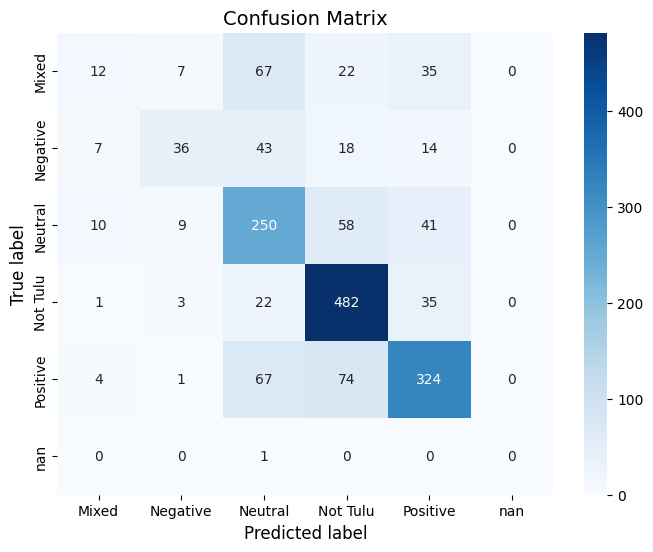

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = best_svm_model.predict(X_val)

cm = confusion_matrix(y_val, y_pred)

class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()
